In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, \
recall_score, cohen_kappa_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
events = pd.read_csv('/users/ganeshmakkina/downloads/archive_8/events.csv')
info = pd.read_csv('/users/ganeshmakkina/downloads/archive_8/ginf.csv')

In [3]:
events = events.merge(info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')
extract_year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
events['year'] = [extract_year(x) for key, x in enumerate(events['date'])]

In [4]:

shots = events[events.event_type==1]
shots['player'] = shots['player'].str.title()
shots['player2'] = shots['player2'].str.title()
shots['country'] = shots['country'].str.title()

/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/681908137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['player'] = shots['player'].str.title()
/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/681908137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['player2'] = shots['player2'].str.title()
/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/681908137.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [5]:
events.head(5)


,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,country,date,year
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0,germany,2011-08-05,2011
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0,germany,2011-08-05,2011


Data Exploration

In [6]:
pie = shots[['shot_outcome', 'id_event']].groupby('shot_outcome').count().reset_index().rename(columns={'id_event': 'count'})

In [7]:
pie.shot_outcome = pie.shot_outcome.astype(int)
pie.shot_outcome = pie.shot_outcome.replace({1: 'On Target', 2: 'Off Target', 3: 'Blocked', 4: 'Hit the Bar'})

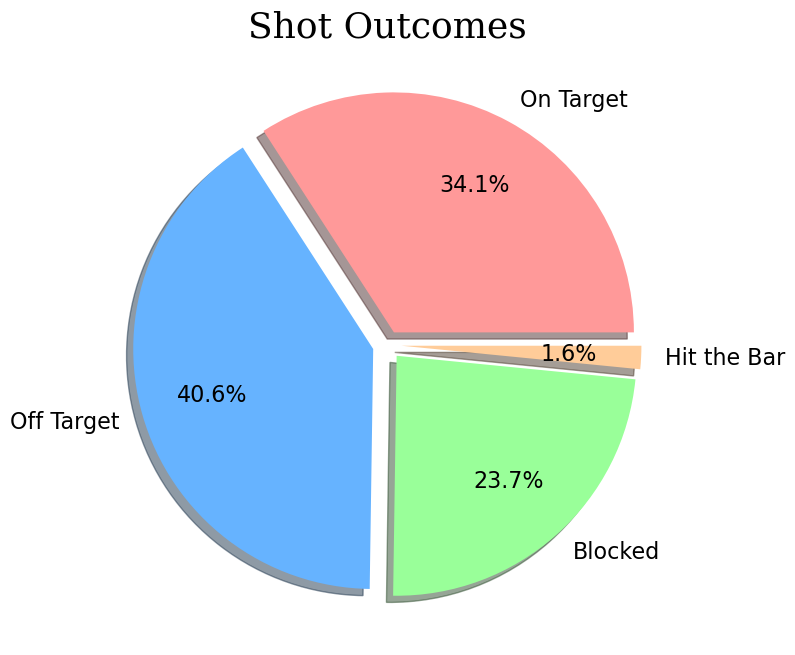

In [8]:
fig, ax = plt.subplots(figsize=[8,8])
labels = pie['shot_outcome']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=pie['count'], autopct="%.1f%%", labels=labels, explode=[0.06]*4, pctdistance=0.7, colors=colors, shadow=True, \
       textprops=dict(fontsize=16))
plt.title("Shot Outcomes", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

In [9]:
bar = shots[['shot_place', 'id_event']].groupby('shot_place').count().reset_index().rename(columns={'id_event': 'count'})

bar.shot_place = bar.shot_place.astype(int)

bar.shot_place = bar.shot_place.replace({1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner', \
                                        5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left', \
                                        9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', \
                                        12: 'Top left corner', 13: 'Top right corner'})

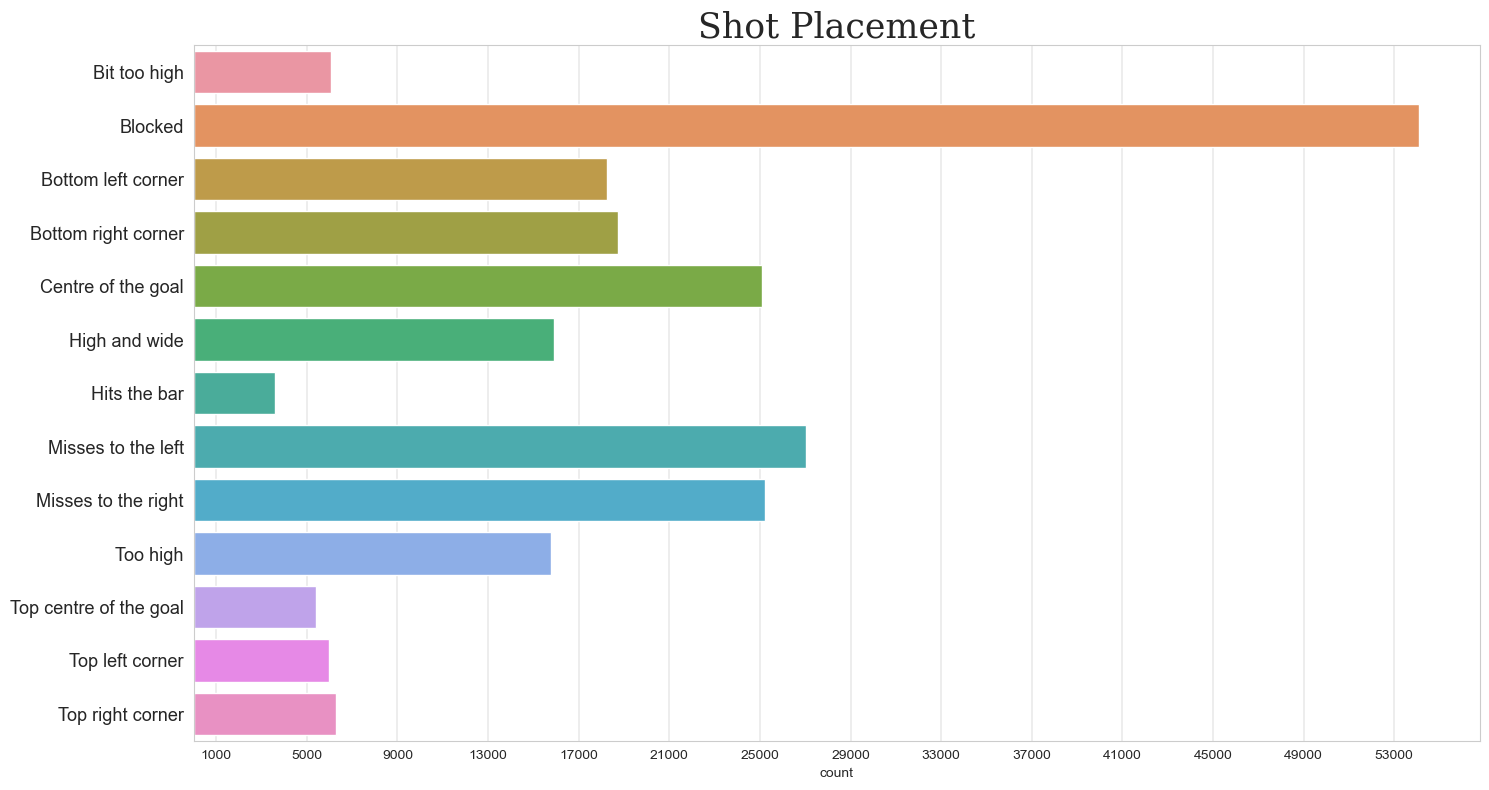

In [10]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[15,8])
labels = bar['shot_place']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(x=bar['count'], y=labels)
ax.set_yticklabels(labels, size = 13)
ax.set_xticks(np.arange(1000,57000,4000))
ax.set_ylabel(ylabel='')
plt.title("Shot Placement", fontsize=25, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

In [11]:
# We'll explore something that will be important for our xG model: which percentage of shots end up as goals. We'll divide this analysis for the different leagues and across years, to check if there are differences in the patterns through different parts of the world or different years.

goals  = shots[['is_goal', 'id_event', 'country']].groupby(['is_goal', 'country']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [12]:
goals['percentage']=0
for i in range(len(goals)):
    for country in goals.country.unique():
        if goals.iloc[i,goals.columns.get_loc("country")]==country:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.country==country]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

In [13]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}%'.format(p.get_height())
            ax.text(_x, _y+2, value, ha="center", fontsize=14) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

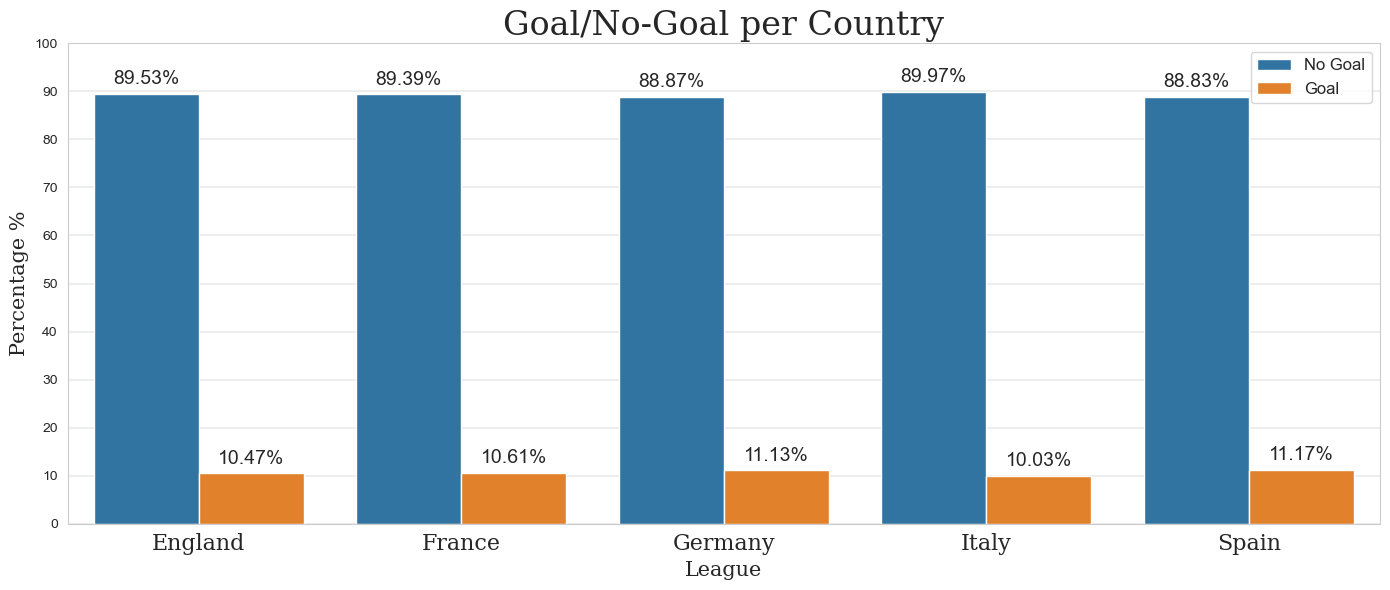

In [14]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='country')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='League', fontsize=15, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Country", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

In [15]:
goals  = shots[['is_goal', 'id_event', 'year']].groupby(['is_goal', 'year']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [16]:
goals['percentage']=0
for i in range(len(goals)):
    for year in goals.year.unique():
        if goals.iloc[i,goals.columns.get_loc("year")]==year:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.year==year]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

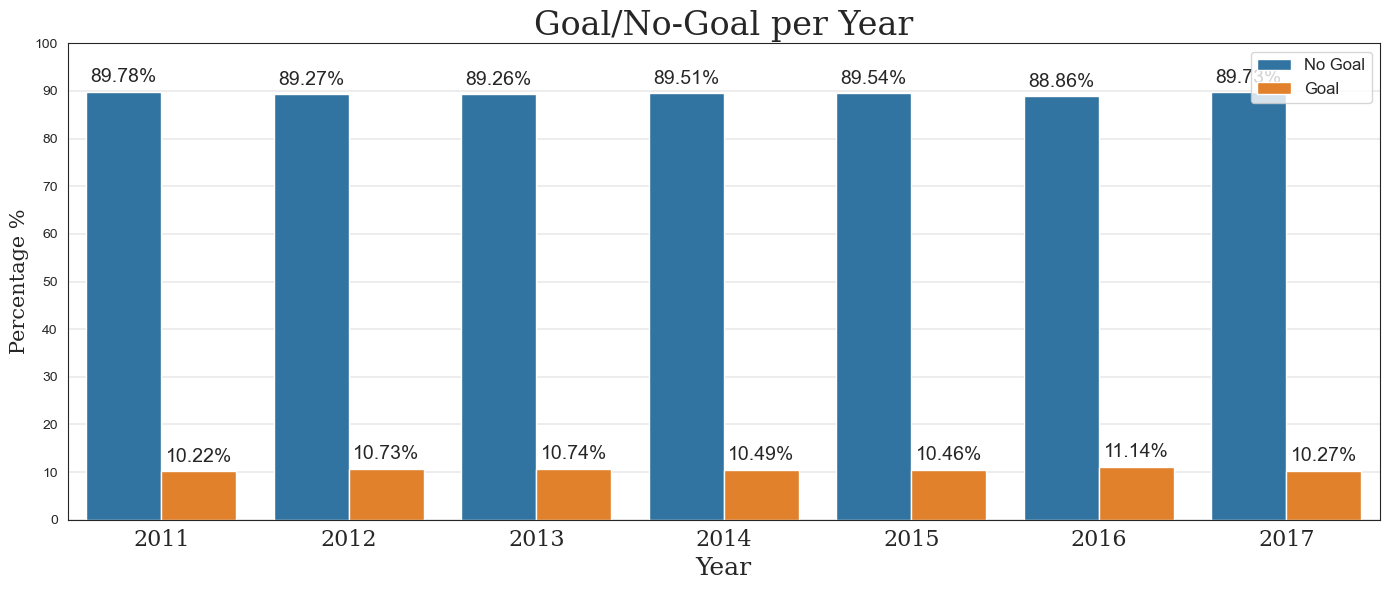

In [17]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='year')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='Year', fontsize=18, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Year", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

xG Model

In [18]:
data = pd.get_dummies(shots.iloc[:,-8:-3], columns=['location', 'bodypart','assist_method', 'situation'])
data.columns = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
                'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
                'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 
                'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
                'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']
data['is_goal'] = shots['is_goal']

In [19]:
print(len(data))
print(data.is_goal.sum())
print(len(data.columns)-1)

229135
24441
28


In [20]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

In [22]:
#pip install hyperopt

  Obtaining dependency information for hyperopt from https://files.pythonhosted.org/packages/b6/cd/5b3334d39276067f54618ce0d0b48ed69d91352fbf137468c7095170d0e5/hyperopt-0.2.7-py2.py3-none-any.whl.metadata
  Obtaining dependency information for py4j from https://files.pythonhosted.org/packages/10/30/a58b32568f1623aaad7db22aa9eafc4c6c194b429ff35bdc55ca2726da47/py4j-0.10.9.7-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 23.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [23]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def evaluate_model(params): 
    model = GradientBoostingClassifier(
                        learning_rate=params['learning_rate'],
                        min_samples_leaf=params['min_samples_leaf'],
                        max_depth = params['max_depth'],
                        max_features = params['max_features']
                        )

    model.fit(X_train, y_train)
    return {
        'learning_rate': params['learning_rate'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_depth': params['max_depth'],
        'max_features': params['max_features'],
        'train_ROCAUC': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
        'test_ROCAUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        'recall': recall_score(y_test, model.predict(X_test)),
        'precision': precision_score(y_test, model.predict(X_test)),
        'f1_score': f1_score(y_test, model.predict(X_test)),
        'train_accuracy': model.score(X_train, y_train),
        'test_accuracy': model.score(X_test, y_test),
    }



def objective(params):
    res = evaluate_model(params)
    
    res['loss'] = - res['test_ROCAUC'] # Esta loss es la que hyperopt intenta minimizar
    res['status'] = STATUS_OK # Asi le decimos a hyperopt que el experimento salio bien
    return res 

hyperparameter_space = {
        'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(15, 200)),
        'max_depth': hp.choice('max_depth', range(2, 20)),
        'max_features': hp.choice('max_features', range(3, 27))
}

In [24]:
trials = Trials()
fmin(
    objective,
    space=hyperparameter_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
);

100%|████████| 50/50 [42:05<00:00, 50.52s/trial, best loss: -0.8194331681439786]


In [25]:
pd.DataFrame(trials.results).sort_values(by='f1_score', ascending=False).head()

,learning_rate,min_samples_leaf,max_depth,max_features,train_ROCAUC,test_ROCAUC,recall,precision,f1_score,train_accuracy,test_accuracy,loss,status
11,0.209156,60,12,23,0.819018,0.818392,0.268932,0.711574,0.390340,0.910586,0.910920,-0.818392,ok
4,0.269756,57,14,15,0.819158,0.818305,0.268815,0.711485,0.390202,0.910606,0.910908,-0.818305,ok
24,0.064035,16,8,12,0.818150,0.819101,0.267874,0.715677,0.389835,0.910519,0.911083,-0.819101,ok
15,0.164436,45,7,24,0.818521,0.818760,0.267992,0.714420,0.389773,0.910492,0.911020,-0.818760,ok
1,0.251997,29,17,22,0.819389,0.818055,0.268579,0.709978,0.389728,0.910640,0.910808,-0.818055,ok


In [26]:
model = GradientBoostingClassifier(
                        learning_rate=0.285508,
                        min_samples_leaf=99,
                        max_depth = 19,
                        max_features = 7
                        )
model.fit(X_train, y_train) 

GradientBoostingClassifier(learning_rate=0.285508, max_depth=19, max_features=7,
                           min_samples_leaf=99)

In [27]:
print('The test set contains {} examples (shots) of which {} are positive (goals).'.format(len(y_test), y_test.sum()))
print('The accuracy of classifying whether a shot is goal or not is {}%.'.format(round(model.score(X_test, y_test)*100),2))
print('Our classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100),2))

The test set contains 80198 examples (shots) of which 8504 are positive (goals).
The accuracy of classifying whether a shot is goal or not is 91%.
Our classifier obtains an ROC-AUC of 82%


So, we can see that our xG model is able to correctly predict whether a shot is goal or not 91% of the times.
Furthermore, we obtain a pretty good ROC-AUC metric of 82%. This looks very promising.

In [28]:
print('The baseline performance for PR-AUC is {}%. This is the PR-AUC that what we would get by random guessing.'.format(round(y_train.mean(),2)))
print('Our model obtains an PR-AUC of {}%.'.format(round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1])*100,2)))
print('Our classifier obtains a Cohen Kappa of {}.'.format(round(cohen_kappa_score(y_test,model.predict(X_test)),2)))

The baseline performance for PR-AUC is 0.11%. This is the PR-AUC that what we would get by random guessing.
Our model obtains an PR-AUC of 47.38%.
Our classifier obtains a Cohen Kappa of 0.35.


In [29]:
print(color.BOLD + color.YELLOW + 'Confusion Matrix:\n' + color.END)
print(confusion_matrix(y_test,model.predict(X_test)))
print(color.BOLD +  color.YELLOW + '\n Report:' + color.END)
print(classification_report(y_test,model.predict(X_test)))

Confusion Matrix:

[[70779   915]
 [ 6235  2269]]

 Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.71      0.27      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



Logistic Regression

In [30]:
model = LogisticRegression(max_iter=400)
model.fit(X_train, y_train)

LogisticRegression(max_iter=400)

In [31]:
print('The test set contains {} examples (shots) of which {} are positive (goals).'.format(len(y_test), y_test.sum()))
print('The accuracy of classifying whether a shot is goal or not is {}%.'.format(round(model.score(X_test, y_test)*100),2))
print('Our classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100),2))

The test set contains 80198 examples (shots) of which 8504 are positive (goals).
The accuracy of classifying whether a shot is goal or not is 91%.
Our classifier obtains an ROC-AUC of 82%


In [32]:
print('The baseline performance for PR-AUC is {}%. This is the PR-AUC that what we would get by random guessing.'.format(round(y_train.mean(),2)))
print('Our model obtains an PR-AUC of {}%.'.format(round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1])*100,2)))
print('Our classifier obtains a Cohen Kappa of {}.'.format(round(cohen_kappa_score(y_test,model.predict(X_test)),2)))

The baseline performance for PR-AUC is 0.11%. This is the PR-AUC that what we would get by random guessing.
Our model obtains an PR-AUC of 47.08%.
Our classifier obtains a Cohen Kappa of 0.35.


In [33]:
print(color.BOLD + color.YELLOW + color.UNDERLINE + 'Confusion Matrix:\n' + color.END)
print(confusion_matrix(y_test,model.predict(X_test)))
print(color.BOLD +  color.YELLOW + color.UNDERLINE + '\n Report:' + color.END)
print(classification_report(y_test,model.predict(X_test)))

Confusion Matrix:

[[70820   874]
 [ 6265  2239]]

 Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.72      0.26      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



In [35]:
model = GradientBoostingClassifier(
                        learning_rate=0.285508,
                        min_samples_leaf=99,
                        max_depth = 19,
                        max_features = 7
                        )
model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.285508, max_depth=19, max_features=7,
                           min_samples_leaf=99)

Feature Importances

In [37]:
#pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 7.3 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107729 sha256=512dc8165a132fabe5c027134c8263c243aa4c354e5ae2349e9213729bc1847f
  Stored in directory: /Users/ganeshmakkina/Library/Caches/pip/wheels/ec/68/a9/de7d374ecb6f53462ce0eec8326fbab91b6228c82e67428d0d
Successfully built eli5
Note: you may need to restart the kernel to use updated packages.


In [38]:
import eli5
eli5.explain_weights(model, feature_names=list(X_train.columns))

Weight,Feature
0.1923 ± 0.1111,close_range
0.1594 ± 0.0686,penalty
0.1543 ± 0.1129,not_recorded
0.1053 ± 0.1050,outside_box
0.0676 ± 0.1303,loc_centre_box
0.0603 ± 0.1041,fast_break
0.0332 ± 0.1546,assist_cross
0.0310 ± 0.0766,assist_through_ball
0.0278 ± 0.1167,open_play
0.0263 ± 0.1413,assist_pass


**Player Analysis**

In [39]:
shots['prediction'] = model.predict_proba(X)[:, 1]
shots['difference'] = shots['prediction'] - shots['is_goal']

/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/3778964094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['prediction'] = model.predict_proba(X)[:, 1]
/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/3778964094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['difference'] = shots['prediction'] - shots['is_goal']


In [40]:
players = shots.groupby('player').sum().reset_index()
players.rename(columns={'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
players.expectedGoals = round(players.expectedGoals,2)
players.difference = round(players.difference,2)
players['ratio'] = players['trueGoals'] / players['expectedGoals']

/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/305844080.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  players = shots.groupby('player').sum().reset_index()


In [41]:
print(round(players.expectedGoals.corr(players.trueGoals),3))

0.977


Best Finishers

In [42]:
show = players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'difference', 'trueGoals', 'expectedGoals']].head(10)
show.head(5)

,rank,player,difference,trueGoals,expectedGoals
0,1,Lionel Messi,-58.89,205,146.11
1,2,Zlatan Ibrahimovic,-33.85,153,119.15
2,3,Cristiano Ronaldo,-32.33,198,165.67
3,4,Luis Suarez,-31.71,96,64.29
4,5,Gonzalo Higuain,-31.50,118,86.50


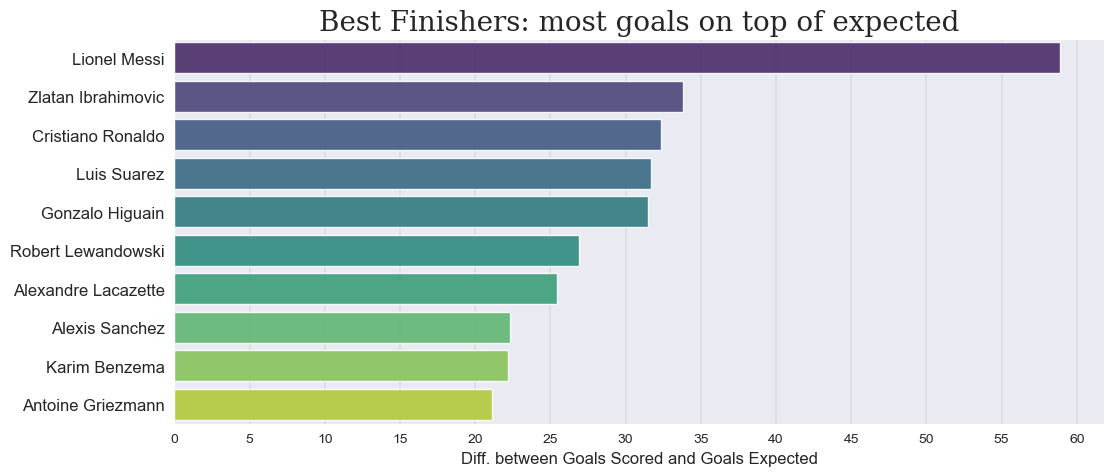

In [43]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=abs(show['difference']), y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,65,5))
ax.set_xlabel(xlabel='Diff. between Goals Scored and Goals Expected', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Finishers: most goals on top of expected", fontsize=20, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, alpha=0.8, axis='x')
plt.show()

In [44]:
show = players[players['trueGoals']>30].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'ratio', 'trueGoals', 'expectedGoals']].head(10)
show.head(10)

,rank,player,ratio,trueGoals,expectedGoals
0,1,Franck Ribery,1.900238,40,21.05
1,2,Mario Gotze,1.587302,37,23.31
2,3,Bas Dost,1.549053,36,23.24
3,4,Heungmin Son,1.523810,32,21.00
4,5,Carlos Tevez,1.493681,39,26.11
5,6,Luis Suarez,1.493234,96,64.29
6,7,Isco,1.453744,33,22.70
7,8,Eden Hazard,1.442867,62,42.97
8,9,Alberto Bueno,1.442741,32,22.18
9,10,Dries Mertens,1.429773,34,23.78


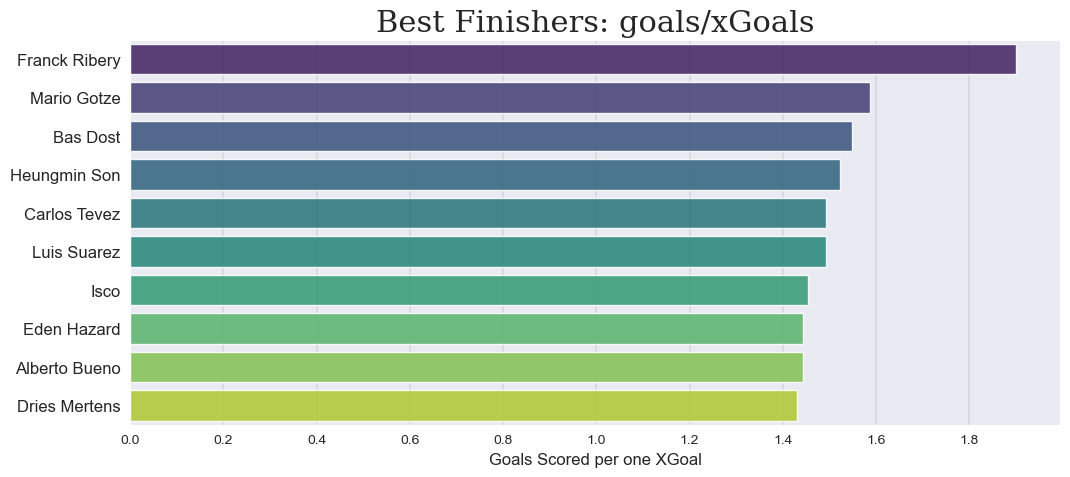

In [45]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,1.9,0.2))
ax.set_xlabel(xlabel='Goals Scored per one XGoal', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Finishers: goals/xGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

b) Best Finishers per Year per League

In [46]:
players_per_year = shots.groupby(['year', 'country', 'player']).sum().reset_index()
players_per_year.rename(columns={'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
players_per_year.expectedGoals = round(players_per_year.expectedGoals,2)
players_per_year.difference = round(players_per_year.difference,2)
players_per_year['ratio'] = players_per_year['trueGoals'] / players_per_year['expectedGoals']
players_per_year['ratio'] = round(players_per_year.ratio, 2)

/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/4169464145.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  players_per_year = shots.groupby(['year', 'country', 'player']).sum().reset_index()


In [47]:
def best_finishers_per_year(years, leagues, min_goals, df):
    years_res=[]; leagues_res=[]; players_res=[]; ratio_res=[]; goals=[]
    players_per_year = df[df['trueGoals']>min_goals]
    for league in leagues:
        for year in years:
            results = players_per_year[(players_per_year['year']==year) & (players_per_year['country']==league)].sort_values(by='ratio', ascending=False).reset_index(drop=True)
            results['rank'] = results.index + 1
            if len(results)>0:
                years_res.append(year)
                leagues_res.append(league)
                players_res.append(results[results['rank']==1]['player'].iloc[0])
                ratio_res.append(results[results['rank']==1]['ratio'].iloc[0])
                goals.append(results[results['rank']==1]['trueGoals'].iloc[0])
    return years_res, leagues_res, players_res, ratio_res, goals

In [48]:
years, leagues, players_res, ratio, goals = best_finishers_per_year(years = players_per_year.year.unique(), leagues=players_per_year.country.unique(),\
                       min_goals=12, df=players_per_year)

In [49]:
results_perYear = pd.DataFrame()
results_perYear['League']=leagues
results_perYear['Year']=years
results_perYear['bestFinisher']=players_res
results_perYear['Goals']=goals
results_perYear['Goals/xGoals Ratio']=ratio
results_perYear

,League,Year,bestFinisher,Goals,Goals/xGoals Ratio
0,France,2011,Olivier Giroud,13,1.23
1,France,2012,Zlatan Ibrahimovic,18,1.47
2,France,2013,Dario Cvitanich,16,1.70
3,France,2014,Cheick Diabate,13,1.61
4,France,2015,Benjamin Moukandjo,13,1.69
5,France,2016,Zlatan Ibrahimovic,21,2.25
6,Germany,2011,Klaasjan Huntelaar,15,1.81
7,Germany,2012,Martin Harnik,15,1.80
8,Germany,2013,Ivica Olic,13,2.23
9,Germany,2014,Josip Drmic,14,2.03


Worst finishers

In [50]:
show = players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'difference', 'trueGoals', 'expectedGoals']].tail(10)
show.tail(5)

,rank,player,difference,trueGoals,expectedGoals
4782,4783,Adrian Mutu,8.58,17,25.58
4783,4784,Giampaolo Pazzini,8.74,31,39.74
4784,4785,Mats Hummels,8.96,10,18.96
4785,4786,Amauri,12.00,20,32.00
4786,4787,Jesus Navas,14.53,9,23.53


In [51]:
show = players[players['trueGoals']>30].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show.sort_values(by='rank', ascending=False)
show = show[['rank', 'player', 'ratio', 'trueGoals', 'expectedGoals']].head(10)
show.head(5)

,rank,player,ratio,trueGoals,expectedGoals
140,141,Giampaolo Pazzini,0.780070,31,39.74
139,140,Mario Balotelli,0.811908,36,44.34
138,139,Gonzalo Bergessio,0.846532,31,36.62
137,138,Mauricio Pinilla,0.869759,39,44.84
136,137,Fabio Quagliarella,0.879765,39,44.33


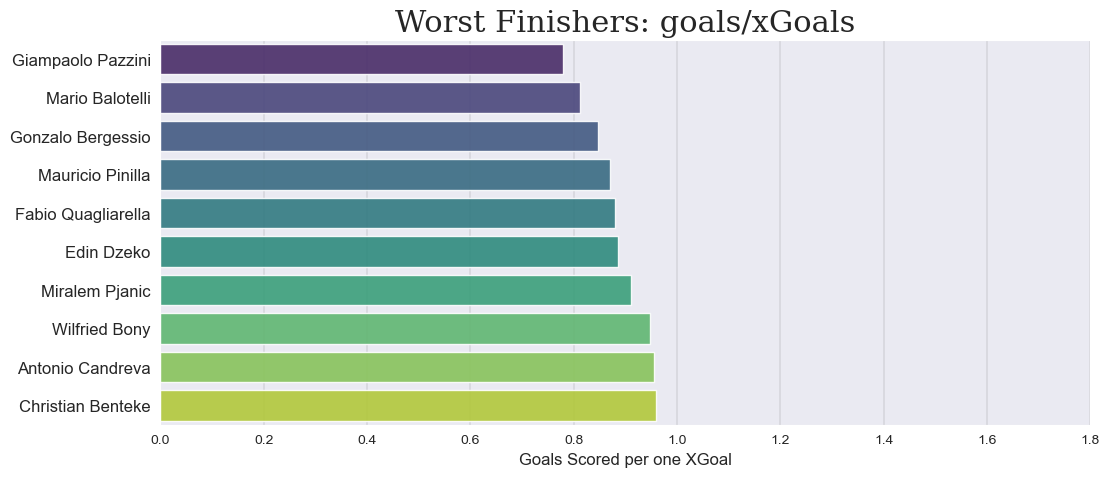

In [52]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,1.9,0.2))
ax.set_xlabel(xlabel='Goals Scored per one XGoal', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Worst Finishers: goals/xGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

Which players have the most "expected goals"?


In [54]:
show = players[['player', 'trueGoals', 'expectedGoals']].sort_values(['expectedGoals'], ascending=False).head(10)
show.head(10)

,player,trueGoals,expectedGoals
944,Cristiano Ronaldo,198,165.67
2745,Lionel Messi,205,146.11
4779,Zlatan Ibrahimovic,153,119.15
1277,Edinson Cavani,121,113.84
3971,Robert Lewandowski,124,97.12
3817,Pierreemerick Aubameyang,100,86.68
1802,Gonzalo Higuain,118,86.50
451,Antonio Di Natale,76,75.83
1183,Diego Costa,93,72.23
1457,Falcao,80,68.33


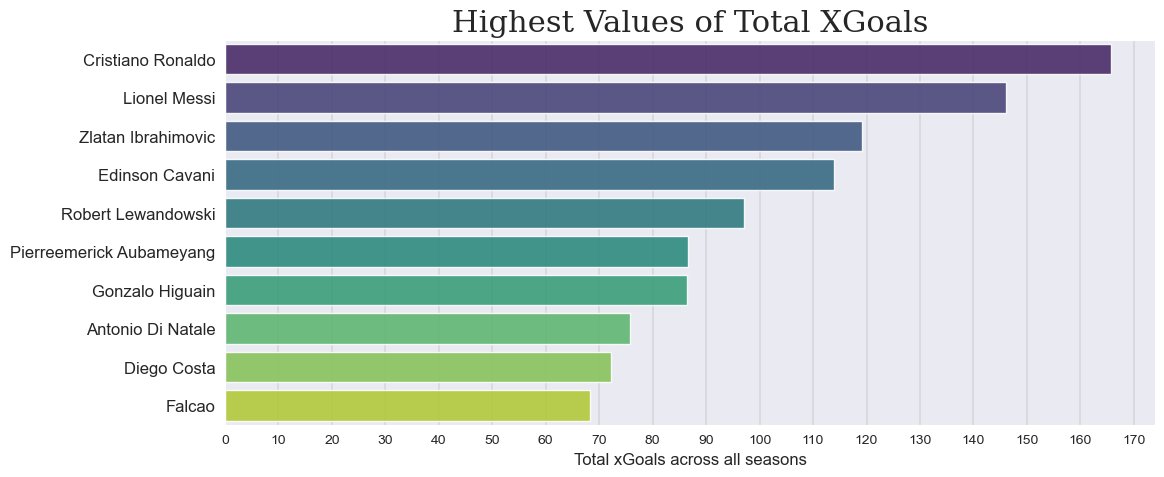

In [55]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['expectedGoals'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,180,10))
ax.set_xlabel(xlabel='Total xGoals across all seasons', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Highest Values of Total XGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

Which players are the worst at deciding their shots

In [56]:
players.rename(columns={'event_type': 'n_shots'}, inplace=True)

In [57]:
players['xG_per_shot_ratio'] = players['expectedGoals'] / players['n_shots']
show = players[players['n_shots']>100].sort_values(['xG_per_shot_ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'xG_per_shot_ratio', 'trueGoals', 'expectedGoals', 'difference']].tail(5)

,rank,player,xG_per_shot_ratio,trueGoals,expectedGoals,difference
669,670,Daniel Baier,0.042203,5,7.47,2.47
670,671,Ivan Radovanovic,0.040994,2,6.60,4.60
671,672,Florent Balmont,0.036786,5,6.18,1.18
672,673,Gokhan Inler,0.035622,9,6.59,-2.41
673,674,Tom Huddlestone,0.030556,2,3.30,1.30


In [58]:
show = show[['rank', 'player', 'xG_per_shot_ratio', 'trueGoals', 'expectedGoals', 'difference']].head(10)
show.head(10)

,rank,player,xG_per_shot_ratio,trueGoals,expectedGoals,difference
0,1,Diego Milito,0.208841,33,28.82,-4.18
1,2,Kevin Gameiro,0.193828,63,58.73,-4.27
2,3,Ikechukwu Uche,0.192655,21,21.77,0.77
3,4,Carlos Bacca,0.191478,57,44.04,-12.96
4,5,Miku,0.191009,23,20.82,-2.18
5,6,Dario Cvitanich,0.190862,30,22.14,-7.86
6,7,Steven Gerrard,0.189126,22,19.48,-2.52
7,8,Jorge Molina,0.185488,29,30.42,1.42
8,9,Claudio Pizarro,0.184100,47,36.82,-10.18
9,10,Edinson Cavani,0.182729,121,113.84,-7.16


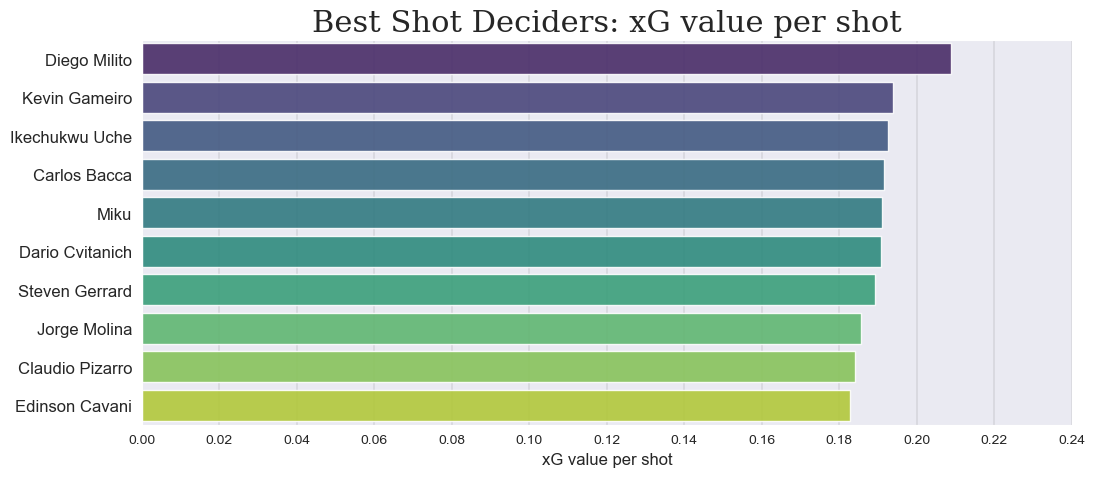

In [59]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['xG_per_shot_ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,0.25,0.02))
ax.set_xlabel(xlabel='xG value per shot', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Shot Deciders: xG value per shot", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

Which players are the best headers?

In [60]:
headers = shots[(shots.event_type==1) & (shots.bodypart==3)]
headers_players = headers.groupby('player').sum().reset_index()
headers_players.rename(columns={'event_type': 'n_headers', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
headers_players['ratio'] = headers_players['trueGoals'] / headers_players['expectedGoals']
show_headers = headers_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show_headers['rank'] = show_headers.index+1
show_headers[['rank', 'player', 'n_headers', 'trueGoals', 'expectedGoals', 'difference']].head(10)

/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/3109011918.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  headers_players = headers.groupby('player').sum().reset_index()


,rank,player,n_headers,trueGoals,expectedGoals,difference
0,1,Cristiano Ronaldo,159,36,20.008446,-15.991554
1,2,Mario Mandzukic,124,28,14.639123,-13.360877
2,3,Fernando Llorente,141,25,15.924137,-9.075863
3,4,Sloan Privat,86,17,9.920512,-7.079488
4,5,Pierreemerick Aubameyang,59,14,7.294977,-6.705023
5,6,Michail Antonio,32,12,5.591541,-6.408459
6,7,Anthony Modeste,104,17,10.924727,-6.075273
7,8,Zlatan Ibrahimovic,91,17,11.032039,-5.967961
8,9,Gareth Bale,73,14,8.046161,-5.953839
9,10,Daniel Sturridge,20,8,2.266233,-5.733767


Which players are the best at shooting with their left foot?

In [61]:
left_foot = shots[(shots.event_type==1) & (shots.bodypart==2)]
left_foot_players = left_foot.groupby('player').sum().reset_index()
left_foot_players.rename(columns={'event_type': 'n_leftFoot_shots', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
show_lfoot = left_foot_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show_lfoot['rank'] = show_lfoot.index+1
show_lfoot[['rank', 'player', 'n_leftFoot_shots', 'trueGoals', 'expectedGoals', 'difference']].head(10)

/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/2956489404.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  left_foot_players = left_foot.groupby('player').sum().reset_index()


,rank,player,n_leftFoot_shots,trueGoals,expectedGoals,difference
0,1,Lionel Messi,752,167,121.496113,-45.503887
1,2,Antoine Griezmann,345,58,41.443383,-16.556617
2,3,Arjen Robben,296,42,32.139170,-9.860830
3,4,Iago Falque,132,23,13.264011,-9.735989
4,5,Franck Ribery,57,16,6.419540,-9.580460
5,6,Mohamed Salah,129,23,13.924673,-9.075327
6,7,Iago Aspas,180,34,25.350698,-8.649302
7,8,Gareth Bale,195,30,22.040888,-7.959112
8,9,Lukas Podolski,132,21,13.202650,-7.797350
9,10,Zlatan Ibrahimovic,129,25,17.239076,-7.760924


In [62]:
left_foot_players['ratio'] = left_foot_players['trueGoals'] / left_foot_players['expectedGoals']
show_lfoot = left_foot_players[left_foot_players['trueGoals']>20].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show_lfoot['rank'] = show_lfoot.index+1
show_lfoot[['rank', 'player', 'n_leftFoot_shots', 'trueGoals', 'expectedGoals', 'ratio']].head(5)

,rank,player,n_leftFoot_shots,trueGoals,expectedGoals,ratio
0,1,Iago Falque,132,23,13.264011,1.734015
1,2,Mohamed Salah,129,23,13.924673,1.651744
2,3,Lukas Podolski,132,21,13.202650,1.590590
3,4,James Rodriguez,162,23,15.535284,1.480501
4,5,Zlatan Ibrahimovic,129,25,17.239076,1.450194


Which players are the best at shooting with their right foot?

In [63]:
right_foot = shots[(shots.event_type==1) & (shots.bodypart==1)]
right_foot_players = right_foot.groupby('player').sum().reset_index()
right_foot_players.rename(columns={'event_type': 'n_rightFoot_shots', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
show = right_foot_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_rightFoot_shots', 'trueGoals', 'expectedGoals', 'difference']].head(5)

/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/3740076464.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  right_foot_players = right_foot.groupby('player').sum().reset_index()


,rank,player,n_rightFoot_shots,trueGoals,expectedGoals,difference
0,1,Luis Suarez,289,69,43.117023,-25.882977
1,2,Gonzalo Higuain,362,86,60.870991,-25.129009
2,3,Alexandre Lacazette,270,70,48.059212,-21.940788
3,4,Zlatan Ibrahimovic,554,111,90.880689,-20.119311
4,5,Robert Lewandowski,378,84,65.432614,-18.567386


In [64]:
right_foot_players['ratio'] = right_foot_players['trueGoals'] / right_foot_players['expectedGoals']
show_rfoot = right_foot_players[right_foot_players['trueGoals']>20].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show_rfoot['rank'] = show_rfoot.index+1
show_rfoot[['rank', 'player', 'n_rightFoot_shots', 'trueGoals', 'expectedGoals', 'ratio']].head(5)

,rank,player,n_rightFoot_shots,trueGoals,expectedGoals,ratio
0,1,Bas Dost,62,23,13.036343,1.764299
1,2,Carlos Tevez,181,33,19.815330,1.665377
2,3,Franck Ribery,165,24,14.427943,1.663439
3,4,Mario Gotze,170,32,19.866276,1.610770
4,5,Lionel Messi,109,30,18.730298,1.601683


In [65]:
right_foot = right_foot_players[right_foot_players['n_rightFoot_shots']>5]
left_foot = left_foot_players[left_foot_players['n_leftFoot_shots']>5]
headers = headers_players[headers_players['n_headers']>5]
all_players = right_foot[['player']].merge(left_foot, on='player', how='inner').merge(headers, on='player', how='inner')                                                                         
all_players_list = list(all_players['player'].unique())

def compare_players(players_list):
    total = right_foot[right_foot['player'].isin(players_list)][['player', 'ratio']]
    total['bodypart']='Right Foot'
    left_foot['bodypart']='Left Foot'
    headers['bodypart']= 'Header'
    total = pd.concat([total, left_foot[left_foot['player'].isin(players_list)][['player', 'ratio', 'bodypart']], headers[headers['player'].isin(players_list)][['player', 'ratio', 'bodypart']]], axis=0)

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=[15,8])
    ax = sns.barplot(y=total['ratio'], x=total['player'], hue=total['bodypart'], palette='viridis', alpha=0.9)
    #ax.set_yticks(np.arange(0,2.2,0.2))
    ax.set_ylabel(ylabel='Goals per xG Ratio', fontsize=14)
    ax.set_xlabel(xlabel='')
    ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)
    plt.title("Players Comparison", fontsize=24, fontfamily='serif')
    ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
    plt.legend(fontsize=12)
    plt.show()


/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/412481114.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_foot['bodypart']='Left Foot'
/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/412481114.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headers['bodypart']= 'Header'


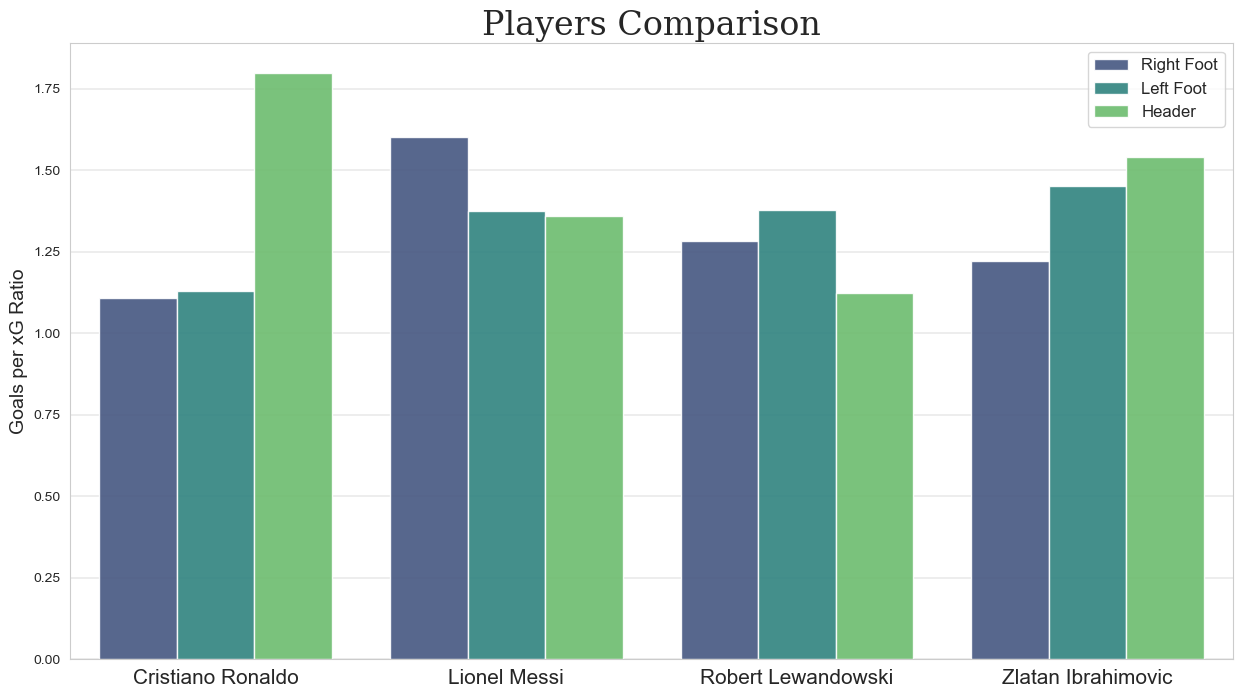

In [66]:
compare_players(players_list = ['Lionel Messi', 'Cristiano Ronaldo', 'Zlatan Ibrahimovic', 'Robert Lewandowski'])

Which are the best outside-the-box shooters?

In [67]:
outside_box = shots[(shots.location==15)]
outbox_players = outside_box.groupby('player').sum().reset_index()
outbox_players.rename(columns={'event_type': 'n_outbox_shots', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
show = outbox_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_outbox_shots', 'trueGoals', 'expectedGoals', 'difference']].head(5)

/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/2594773854.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  outbox_players = outside_box.groupby('player').sum().reset_index()


,rank,player,n_outbox_shots,trueGoals,expectedGoals,difference
0,1,Lionel Messi,304,16,6.380277,-9.619723
1,2,Paul Pogba,226,14,5.986120,-8.013880
2,3,Zlatan Ibrahimovic,261,14,6.782105,-7.217895
3,4,Gonzalo Higuain,127,11,3.865004,-7.134996
4,5,Yaya Toure,128,10,3.379578,-6.620422


In [68]:
outbox_players['ratio'] = outbox_players['trueGoals'] / outbox_players['expectedGoals']
show = outbox_players[outbox_players['n_outbox_shots']>80].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'n_outbox_shots', 'trueGoals', 'expectedGoals', 'ratio']].head(10)
show.head(5)

,rank,player,n_outbox_shots,trueGoals,expectedGoals,ratio
0,1,James Rodriguez,105,9,2.422168,3.715679
1,2,Alain Traore,86,6,1.831915,3.275262
2,3,Julian Draxler,94,8,2.613559,3.060960
3,4,Alexandre Lacazette,100,9,2.953168,3.047574
4,5,Yaya Toure,128,10,3.379578,2.958950


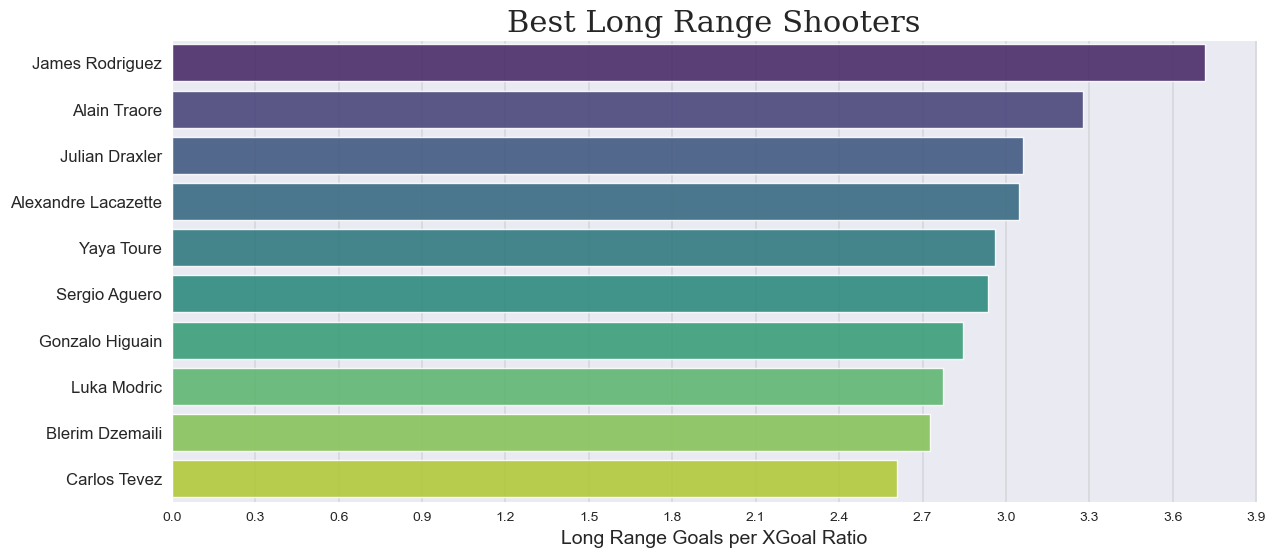

In [69]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[14,6])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,4,0.3))
ax.set_xlabel(xlabel='Long Range Goals per XGoal Ratio', fontsize=14)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Long Range Shooters", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

Which players make the best/most dangerous passes?

In [70]:
passing = shots[shots.assist_method.isin([1,4])]
passing_players = passing.groupby('player2').sum().reset_index()
passing_players.rename(columns={'player2': 'player', 'event_type': 'n_passes', 'is_goal': 'trueGoals_created', 'prediction': 'expectedGoals_created'}, inplace=True)
show = passing_players.sort_values('expectedGoals_created', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created']].head(5)

/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/2986369943.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  passing_players = passing.groupby('player2').sum().reset_index()


,rank,player,n_passes,trueGoals_created,expectedGoals_created
0,1,Lionel Messi,350,68,51.237638
1,2,Mesut Ozil,343,35,36.858677
2,3,Cesc Fabregas,264,53,36.243119
3,4,Zlatan Ibrahimovic,270,36,36.215764
4,5,Marek Hamsik,370,50,34.911078


In [71]:
show['xG_perpass'] = show['expectedGoals_created'] / show['n_passes']
show = show[show['n_passes']>90].sort_values('xG_perpass', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'n_passes', 'xG_perpass']].head(10)
show.head(5)

,rank,player,n_passes,xG_perpass
0,1,Luis Suarez,185,0.165453
1,2,Gareth Bale,109,0.156304
2,3,Angel Di Maria,211,0.150837
3,4,Lionel Messi,350,0.146393
4,5,Neymar,179,0.144678


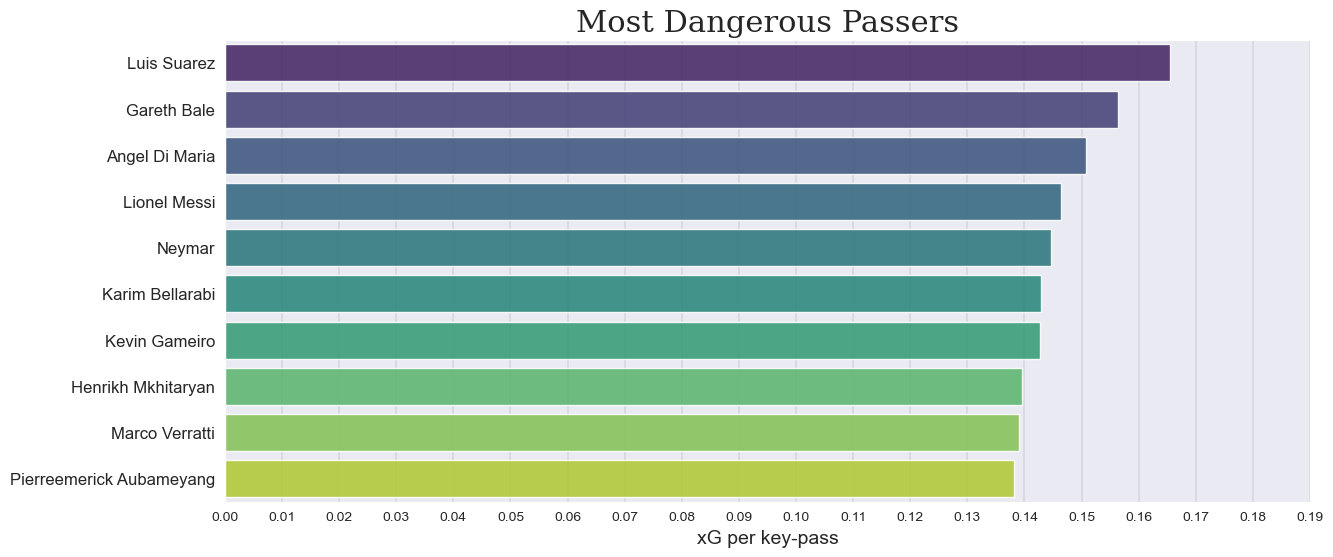

In [72]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[14,6])
ax = sns.barplot(x=show['xG_perpass'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,0.2,0.01))
ax.set_xlabel(xlabel='xG per key-pass', fontsize=14)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Most Dangerous Passers", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

Which players are the most unlucky when passing the ball?

In [73]:
passing = shots[shots.assist_method.isin([1,4])]
passing_players = passing.groupby('player2').sum().reset_index()
passing_players.rename(columns={'player2': 'player', 'event_type': 'n_passes', 'is_goal': 'trueGoals_created', 'prediction': 'expectedGoals_created'}, inplace=True)
show = passing_players[passing_players['n_passes']>50].sort_values('difference', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created', 'difference']].head(10)

/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_44169/3105748214.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  passing_players = passing.groupby('player2').sum().reset_index()


,rank,player,n_passes,trueGoals_created,expectedGoals_created,difference
0,1,Joan Verdu,134,7,14.541770,7.541770
1,2,Xabi Prieto,152,6,13.207612,7.207612
2,3,Philippe Coutinho,177,13,19.891761,6.891761
3,4,Luca Cigarini,164,6,12.804007,6.804007
4,5,Alejandro Gomez,137,5,11.773316,6.773316
5,6,Antonio Di Natale,136,7,13.212459,6.212459
6,7,Victor Ibarbo,116,6,12.130608,6.130608
7,8,Nolito,179,18,23.804510,5.804510
8,9,Mariano,100,2,7.772354,5.772354
9,10,Ever Banega,147,8,13.524610,5.524610


In [74]:
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created', 'difference']].tail(5)

,rank,player,n_passes,trueGoals_created,expectedGoals_created,difference
686,687,Marek Hamsik,370,50,34.911078,-15.088922
687,688,Cristiano Ronaldo,222,45,29.156551,-15.843449
688,689,Karim Benzema,214,40,23.427282,-16.572718
689,690,Cesc Fabregas,264,53,36.243119,-16.756881
690,691,Lionel Messi,350,68,51.237638,-16.762362
